In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
import torch 
from sklearn.datasets import load_diabetes
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor, PreprocessorClassification

In [26]:
from PFNExperiments.Evaluation.RealWorldEvaluation.EvaluateRealWorld import EvaluateRealWorld, results_dict_to_latent_variable_beta0_and_beta

from PFNExperiments.LinearRegression.GenerativeModels.LM_abstract import return_only_y, print_code

from PFNExperiments.LinearRegression.ComparisonModels.Variational_InferenceAutoguide import Variational_InferenceAutoguide
from PFNExperiments.LinearRegression.ComparisonModels.Hamiltionion_MC import Hamiltionian_MC

from PFNExperiments.LinearRegression.ComparisonModels.AnalyticalSolutionsLM import PosteriorLM_IG
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLaplaceApproximation, AutoIAFNormal, AutoStructured

In [27]:
from PFNExperiments.Evaluation.RealWorldEvaluation.PreprocessDataset import Preprocessor
from PFNExperiments.Evaluation.RealWorldEvaluation.GetDataOpenML import GetDataOpenML
getdata = GetDataOpenML(
    preprocessor = PreprocessorClassification(
        N_datapoints = 50,
        P_features = 5,
    ),
    save_path = "C:/Users/arik_/Documents/Dokumente/Job_Clausthal/PFNs/Repository/PFNExperiments/Evaluation/RealWorldEvaluation/DatasetsOpenML/Tabular_benchmark_numerical_regression.pkl",
    benchmark_id = 336
)
datasets = getdata.get_data()

C:\Users\arik_\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
C:\Users\arik_\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
c:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\.conda\lib\site-packages\sklearn\preprocessing\_data.py:3442: RuntimeWarning: overflow encountered in power
  out[~pos] = -(np.power(-x[~pos] + 1, 2 - lmbda) - 1) / (2 - lmbda)


An error The algorithm terminated without finding a valid bracket. Consider trying different initial points. occured while preprocessing the dataset with id 361084. Skipping the dataset
An error The number of features is smaller than the number of features to use occured while preprocessing the dataset with id 361086. Skipping the dataset


In [28]:
from PFNExperiments.LinearRegression.GenerativeModels.GenerateData_LogReg import make_logreg_program_ig_intercept_batched, make_logreg_program_intercept_ig

make_lm_program = make_logreg_program_intercept_ig
make_lm_program_batched = make_logreg_program_ig_intercept_batched

In [29]:
a = 5.0
b = 2.0
tau = 1.0

N_SAMPLES_PER_MODEL = 100

pprogram1 = make_lm_program(tau = tau, a = a, b = b)

pprogram1_y = return_only_y(pprogram1)

"""
analytical_solution = PosteriorLM_IG(
    pprogram_dict= {
        "tau": tau,
        "a": a,
        "b": b
    },
    n_samples=N_SAMPLES_PER_MODEL
)
"""

vi_diag = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoDiagonalNormal,
    n_steps = 1000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)

vi_multivariate_normal = Variational_InferenceAutoguide(
    pprogram=pprogram1_y,
    make_guide_fun = AutoMultivariateNormal,
    n_steps = 1000,
    n_samples=N_SAMPLES_PER_MODEL,
    lr = 1e-2
)


hmc_sampler = Hamiltionian_MC(pprogram = pprogram1_y, n_warmup=500, n_samples=N_SAMPLES_PER_MODEL)

In [30]:
for d in datasets:
    med_y = torch.median(d["y"])
    y = (d["y"] > med_y)
    d["y"] = y

In [31]:
eval = EvaluateRealWorld(
    
    posterior_model = vi_multivariate_normal,
    evaluation_datasets = datasets,
    comparison_models = [vi_diag, 
                         ],
    n_evaluation_cases = 2,
    model_names=["VI Multivariate Normal",
                 "VI Diagonal Normal",
                ],
    results_dict_to_latent_variable_posterior_model = results_dict_to_latent_variable_beta0_and_beta
)

In [32]:
eval.run_evaluation()

Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]C:\Users\arik_\Documents\Dokumente\Job_Clausthal\PFNs\Repository\PFNExperiments\Evaluation\RealWorldEvaluation\EvaluateRealWorld.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype = torch.float32)


..........

Sampling posterior:  50%|█████     | 1/2 [00:07<00:07,  7.37s/it]


..........

Sampling posterior: 100%|██████████| 2/2 [00:14<00:00,  7.10s/it]


Sampling posterior:   0%|          | 0/2 [00:00<?, ?it/s]

..........

Sampling posterior:  50%|█████     | 1/2 [00:04<00:04,  4.93s/it]


..........

Sampling posterior: 100%|██████████| 2/2 [00:10<00:00,  5.15s/it]

Comparison to ground truth:

Summarized results:

Comparison among models:

Summarized results:


,Model 1,Model 2,Mean_Wasserstein_distance with metric euclidean,Mean_MMD,Mean_cst_roc_auc,Std_Wasserstein_distance with metric euclidean,Std_MMD,Std_cst_roc_auc
0,VI Multivariate Normal,VI Diagonal Normal,1.058247,0.278418,0.7075,0.06399,0.118254,0.010607


P-values:


""


{'summarized_results': {'model_comparison_among_each_other':                   Model 1             Model 2  \
  0  VI Multivariate Normal  VI Diagonal Normal   
  
     Mean_Wasserstein_distance with metric euclidean  Mean_MMD  \
  0                                         1.058247  0.278418   
  
     Mean_cst_roc_auc  Std_Wasserstein_distance with metric euclidean   Std_MMD  \
  0            0.7075                                         0.06399  0.118254   
  
     Std_cst_roc_auc  
  0         0.010607  },
 'test_results': {'model_comparison_among_each_other': Empty DataFrame
  Columns: []
  Index: []},
 'res_df': {'model_comparison_among_each_other': {('VI Multivariate Normal',
    'VI Diagonal Normal'):    Wasserstein_distance with metric euclidean       MMD  cst_roc_auc
   0                                    1.103495  0.362036        0.715
   1                                    1.012999  0.194800        0.700}}}

In [33]:
eval.posterior_model_samples

[{'_AutoMultivariateNormal_latent': tensor([[-1.1971, -1.8581, -1.6806,  1.3275,  1.7052,  0.7239, -0.1037],
          [-1.0267, -0.8545, -1.8342, -0.0861,  1.6777,  0.4005,  0.3647],
          [-0.7159, -0.3565, -1.2184,  0.6421,  0.9724,  2.1196, -1.1287],
          [-0.2157, -0.9283, -0.6720,  0.4510,  1.2531,  0.1795,  0.6068],
          [-0.8706, -0.6810, -1.7589,  0.5167,  0.5725,  1.1072, -0.2540],
          [-1.7620,  0.1685, -2.9091, -0.0950,  0.2616,  0.4178,  0.7707],
          [-0.8679, -0.2280, -1.3120,  0.4015,  0.3282,  1.3403, -0.2503],
          [-0.8724, -1.5265, -2.0536,  0.4909,  1.4807,  1.3938,  0.3879],
          [-1.3668, -0.8190, -1.7027,  0.5527,  1.8112,  0.1765, -0.4002],
          [-0.4997,  0.4412, -1.1334,  1.3204,  0.1934,  1.5006, -0.9128],
          [-1.6445, -0.7928, -2.2818, -0.3436, -0.7177,  1.5978,  1.2136],
          [ 0.4224, -1.5067, -2.7505,  1.0229,  0.9364,  0.7350,  0.5779],
          [ 0.0427, -1.1502, -2.2860,  1.0056,  0.0679,  0.9972,  

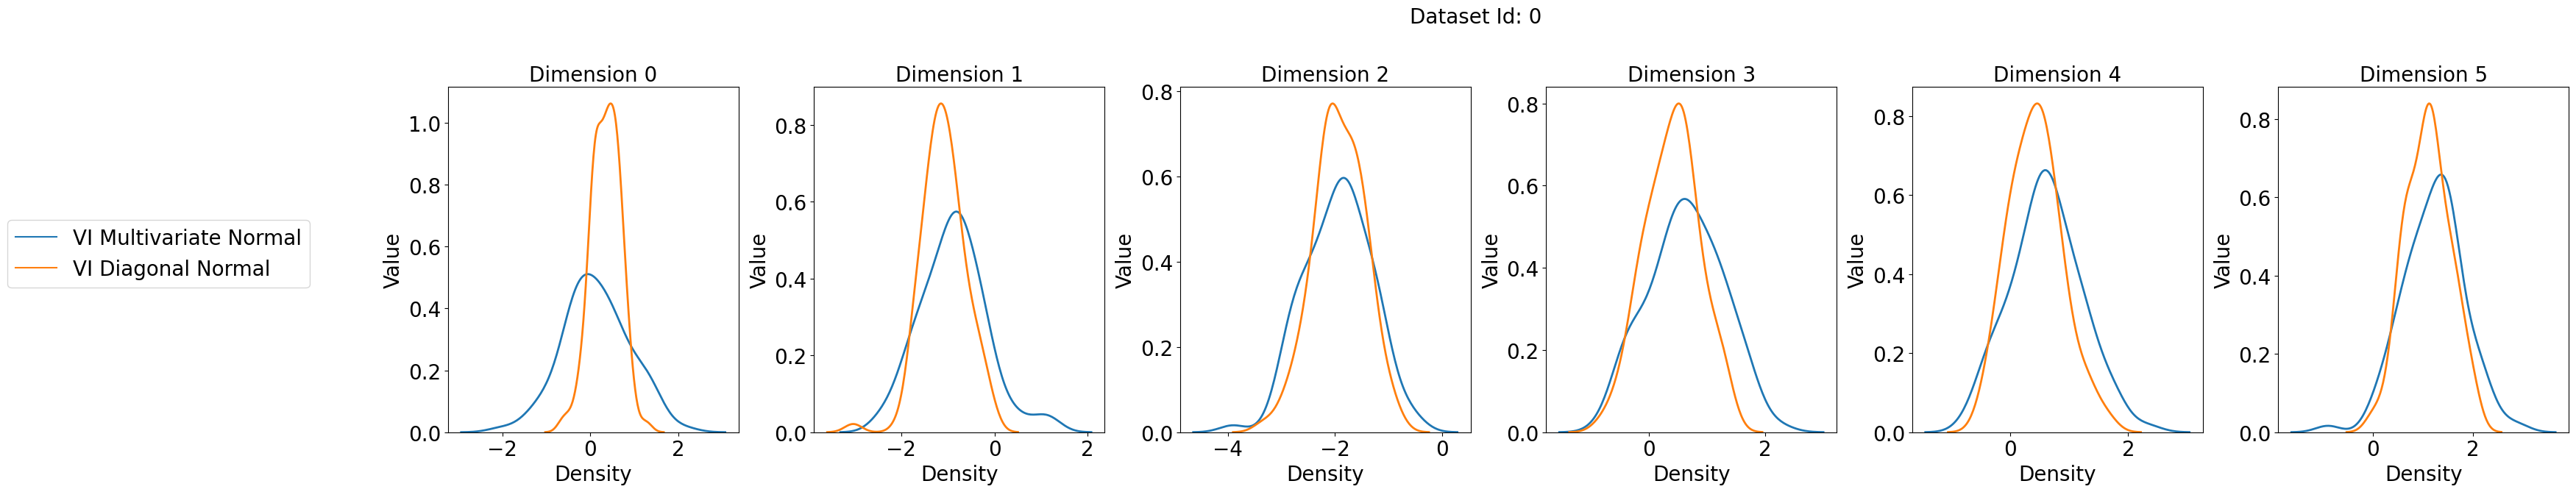

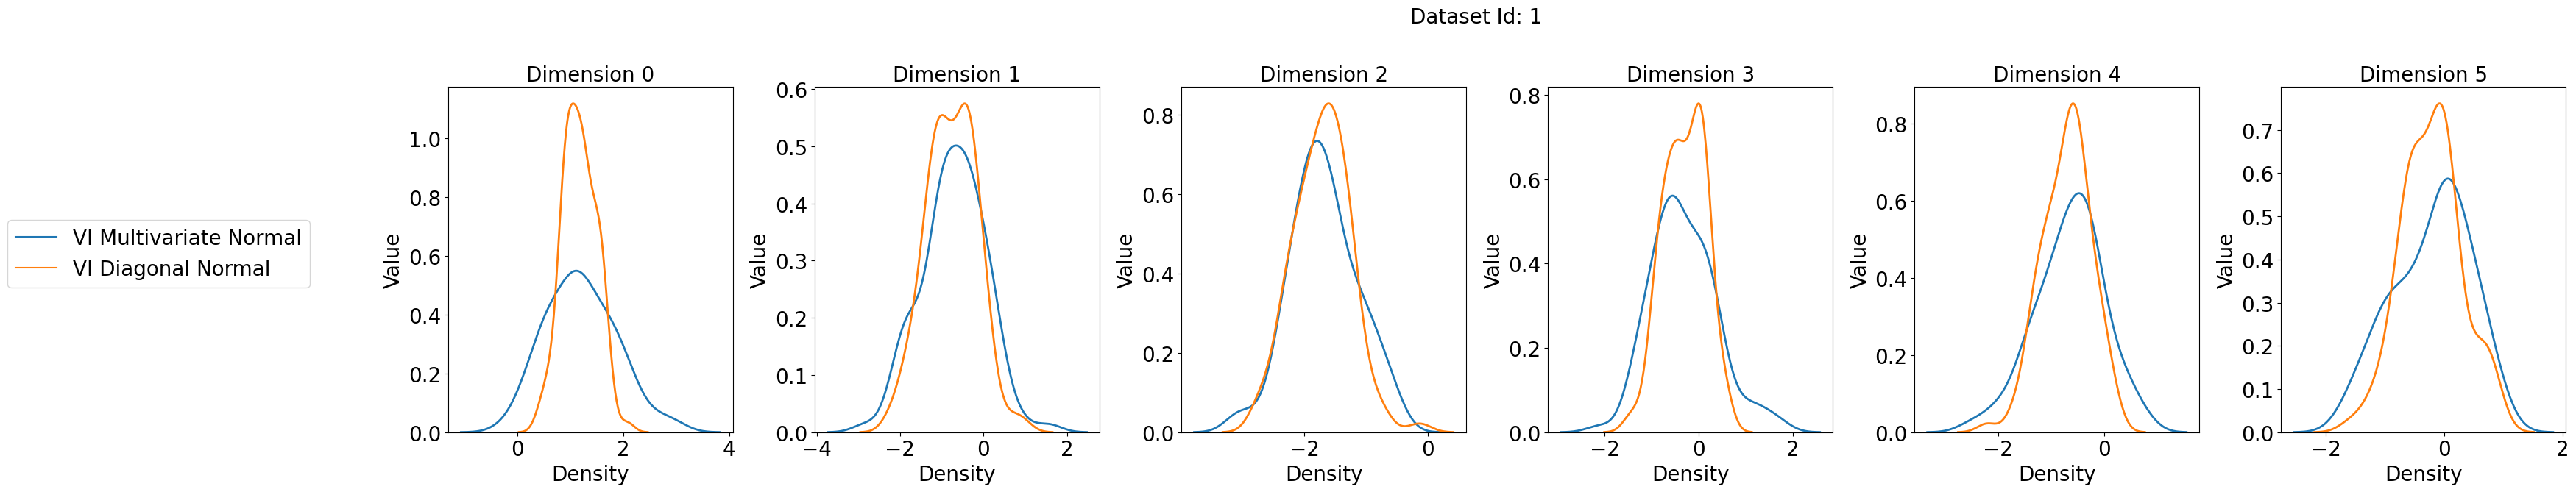

In [41]:
eval.plot_results(max_number_plots=20, fontsize = 20)